In [1]:
%matplotlib inline

# DSCI-508 Project 8
Matt Snyder
## PCA example with **Titanic** Data-set

Principal Component Analysis applied to the Titanic dataset.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### First, Data Exploration

Review columns, see which are independent and which is the target column, which are numeric and which are categorical

In [3]:
df = pd.read_csv('titanic-train.csv')
df_test = pd.read_csv('titanic-test.csv')
df_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


**This is a problem: no Survived column**

For some reason, the titanic-test csv for the assignment does not have a Survived column.  Instead, switch to the titanic set that comes with SNS and split into train and test.

In [4]:
df = sns.load_dataset('titanic')

In [5]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [6]:
X = df.drop('survived',axis=1)
y = df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

**Why are there NaNs in Cabin/deck column?**

The cabin or (related) deck column would probably be valuable for prediction, but it is apparently sparsely populated, so we should not use it for prediction.  The one non-numeric column we *know* is relevant for prediction is Sex, so convert it to numeric with a simple list comprehension.

In [7]:
df.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

**Convert categorical to numeric with simple list comprehension**

In [8]:
# check if there are any data points without male or female
unique_values = np.unique(df['sex'].values)
print(f'Unique gender values: {unique_values}')
# unique_values = np.unique(df_test['sex'].values)
# print(f'Unique gender values in test data: {unique_values}')

# encode gender
gender_list = [0 if sex == 'male' else 1 for sex in df['sex'].values]
gender_numeric = np.array(gender_list)
df['GenderNumeric'] = gender_numeric

# #encode class
# unique_values = np.unique(df['class'].values)
# print(f'Unique class values: {unique_values}')
# class_list = [1 if c == 'First' else 2 if c == 'Second' else 3 for c in df['class'].values]
# class_numeric = np.array(class_list)
# df['ClassNumeric'] = class_numeric

# # encode gender for testing
# gender_list = [0 if sex == 'male' else 1 for sex in df_test['sex'].values]
# gender_numeric = np.array(gender_list)
# df_test['GenderNumeric'] = gender_numeric

df.head()

Unique gender values: ['female' 'male']


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,GenderNumeric
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,1
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,1
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,1
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0


**What is Parch?**

Parch is the number of onboard parents or children associated with the passenger.  See how it is distributed with a histogram.

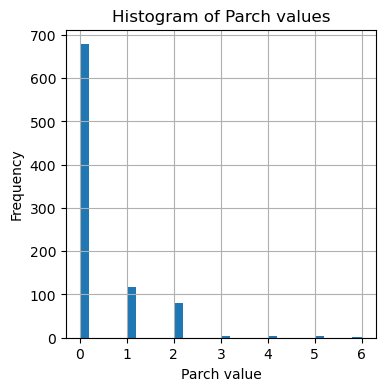

In [9]:
plt.figure(figsize=[4,4])
df.loc[:,'parch'].hist(bins=30)
plt.title('Histogram of Parch values')
plt.xlabel('Parch value')
plt.ylabel('Frequency')
plt.show()

**Replace Nan's with Column Mean for Floats**

In [10]:
# Age
mean = df['age'].mean()
df['age'] = df['age'].fillna(mean)
# mean = df_test['age'].mean()
# df_test['age'] = df_test['age'].fillna(mean)

# Fare
mean = df['fare'].mean()
df['fare'] = df['fare'].fillna(mean)
# mean = df_test['fare'].mean()
# df_test['fare'] = df_test['fare'].fillna(mean)

**Check floats for outliers using histograms**

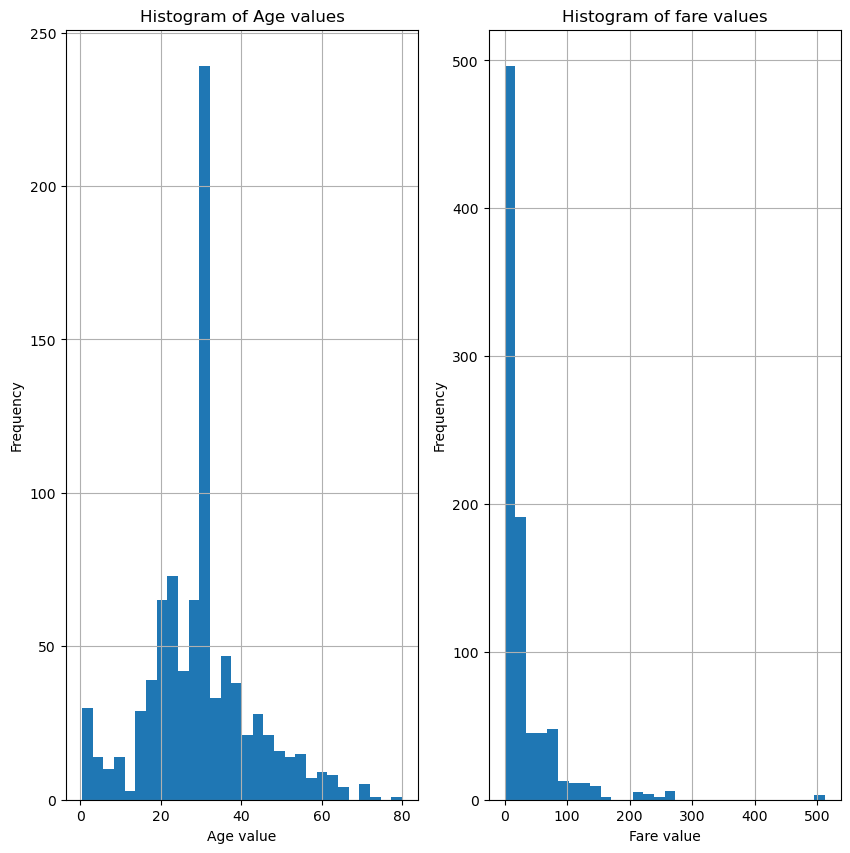

In [11]:
plt.figure(figsize=[10,10])

# Age
plt.subplot(1,2,1)
df.loc[:,'age'].hist(bins=30)
plt.title('Histogram of Age values')
plt.xlabel('Age value')
plt.ylabel('Frequency')

# Age
plt.subplot(1,2,2)
df.loc[:,'fare'].hist(bins=30)
plt.title('Histogram of fare values')
plt.xlabel('Fare value')
plt.ylabel('Frequency')

plt.show()

**Truncate outliers and Normalize**

In [12]:
# Clip the much higher fares
df['fare'] = np.clip(df['fare'].values, a_min=0, a_max=150)

# Normalize
scaler = StandardScaler()
df['FareNorm'] = scaler.fit_transform(df.loc[:,['fare']])
df['AgeNorm'] = scaler.fit_transform(df.loc[:,['age']])

df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,GenderNumeric,FareNorm,AgeNorm
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0,-0.645209,-0.592481
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,1,1.232768,0.638789
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,1,-0.625413,-0.284663
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,1,0.699486,0.407926
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0,-0.621747,0.407926


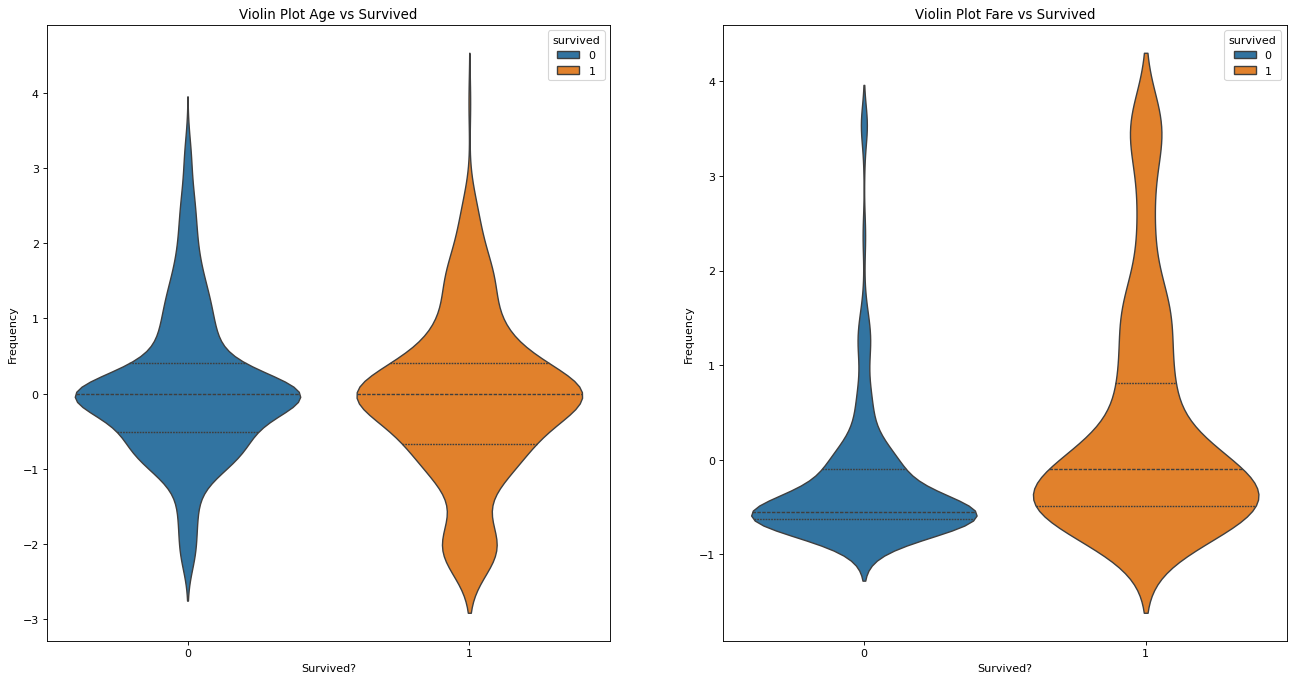

In [13]:
# show violin plots
plt.figure(figsize = (20, 10), dpi= 80)

# Age
plt.subplot(1,2,1)
sns.violinplot(x = "survived", y = "AgeNorm", data = df, density_norm = 'width', 
               inner = 'quartile',hue = "survived")
plt.title("Violin Plot Age vs Survived")
plt.ylabel('Frequency')
plt.xlabel('Survived?')

# Fare
plt.subplot(1,2,2)
sns.violinplot(x = "survived", y = "FareNorm", data = df, density_norm = 'width', 
               inner = 'quartile',hue = "survived")
plt.title("Violin Plot Fare vs Survived")
plt.ylabel('Frequency')
plt.xlabel('Survived?')

plt.show()

**Select numeric columns for modeling**

In [14]:
X_numeric = df.loc[:, ['pclass', 'age', 'sibsp', 'parch', 'fare', 'adult_male', 'alone', 'GenderNumeric']]
# X_test = df_test.loc[:, ['Pclass', 'Age', 'Parch', 'Fare', 'GenderNumeric']]
# y_train = df.loc[:, ['survived']].values[:, 0]
# y_test = df_test.loc[:, ['Survived']].values[:, 0]
# y_train.shape
# df_test.head()
y = df['survived']
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.30)

### PCA Transformation

**First, make Skree plot**

To see how many components we need to capture most of the variance

eigenvalues: [1.10046026e+03 1.57588878e+02 1.28244773e+00 4.75890158e-01
 3.56882200e-01 2.88736308e-01] 
eigenvalue percentages: [0.9799 0.0201 0.     0.     0.     0.    ]


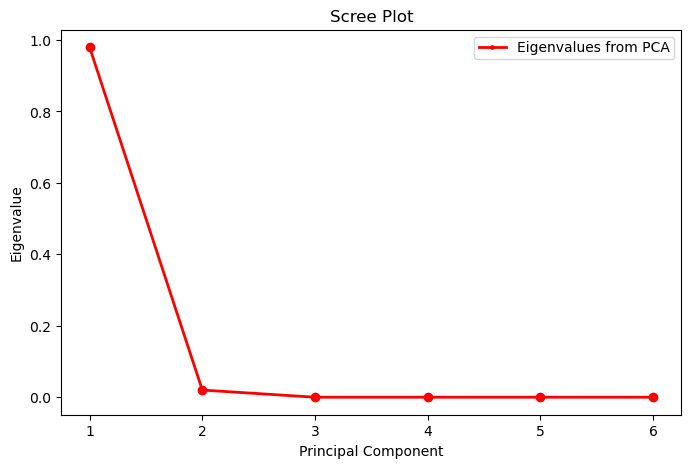

In [15]:
# first with no component reduction, i.e. 6 components
comp_count = 6
pca = decomposition.PCA(n_components=comp_count)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
 
# get eigenvalues
raw_eigVal = pca.explained_variance_
# convert eigenvalues to percents
eigvals=np.round(sorted(raw_eigVal**2 / np.sum(raw_eigVal**2),key=abs,reverse=True),4) 
print(f'eigenvalues: {raw_eigVal} \neigenvalue percentages: {eigvals}')
fig = plt.figure(figsize=(8,5))
plt.plot(np.arange(comp_count)+1, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
leg = plt.legend(['Eigenvalues from PCA'], loc='best', borderpad=0.3, markerscale=0.4)
plt.show()

**Assessment**

We know that "women and children" were most likely to survive, so this first component is probably a linear combination of gender and age primarily, plus class.  Still, it's surprising that 98% of variance is captured in one component

**Redo PCA with 2 components**

Since the scree plot tells us we need only 2 components, redo the PCA with components=2

In [16]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)
X_train_pc.shape

(623, 2)

**Visualize transformed data**

Since their is only 2 components, we can do a 2D scatter plot instead of 3D

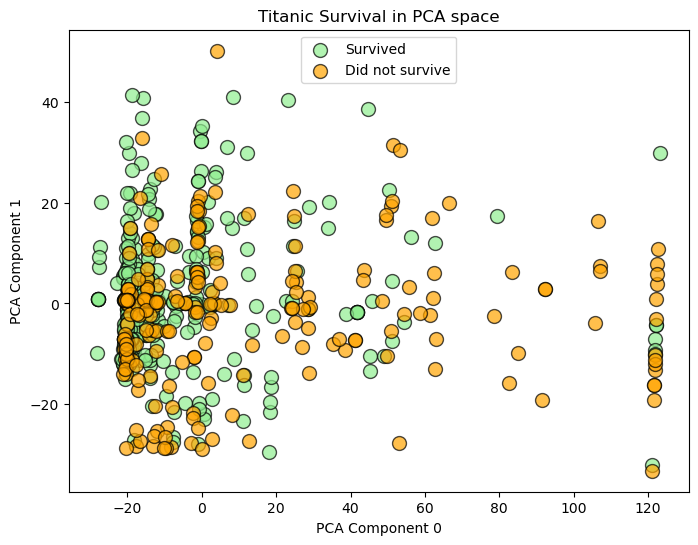

In [17]:
target_labels = ['Survived', 'Did not survive']
color_list = ['lightgreen', 'orange']

plt.figure(figsize=[8,6])

for survived in range(0, 2): # 0 and 1
    mask = (y_train == survived)
    x_plot = X_train_pc[:,0][mask]
    y_plot = X_train_pc[:,1][mask]
    # y_plot = np.array([X_train_pc[i, 0] for i in range(0, len(X_train_pc)) if y[i] == survived])
    # x_plot = np.full(len(y_plot), survived)
    plt.scatter(x=x_plot, y=y_plot, s=100, alpha=0.7,
                color=color_list[survived], edgecolor='black', label=target_labels[survived])

# plt.scatter(x=X_train_pc[:,0], y=y)

plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')
plt.title('Titanic Survival in PCA space')
plt.legend(loc='upper center')
plt.show()

## SVM example with **Titanic** Data-set

Follow the same pattern as the course demonstration, initially not using PCA transformation

### Exploratory Data Analysis

**Pair plot**

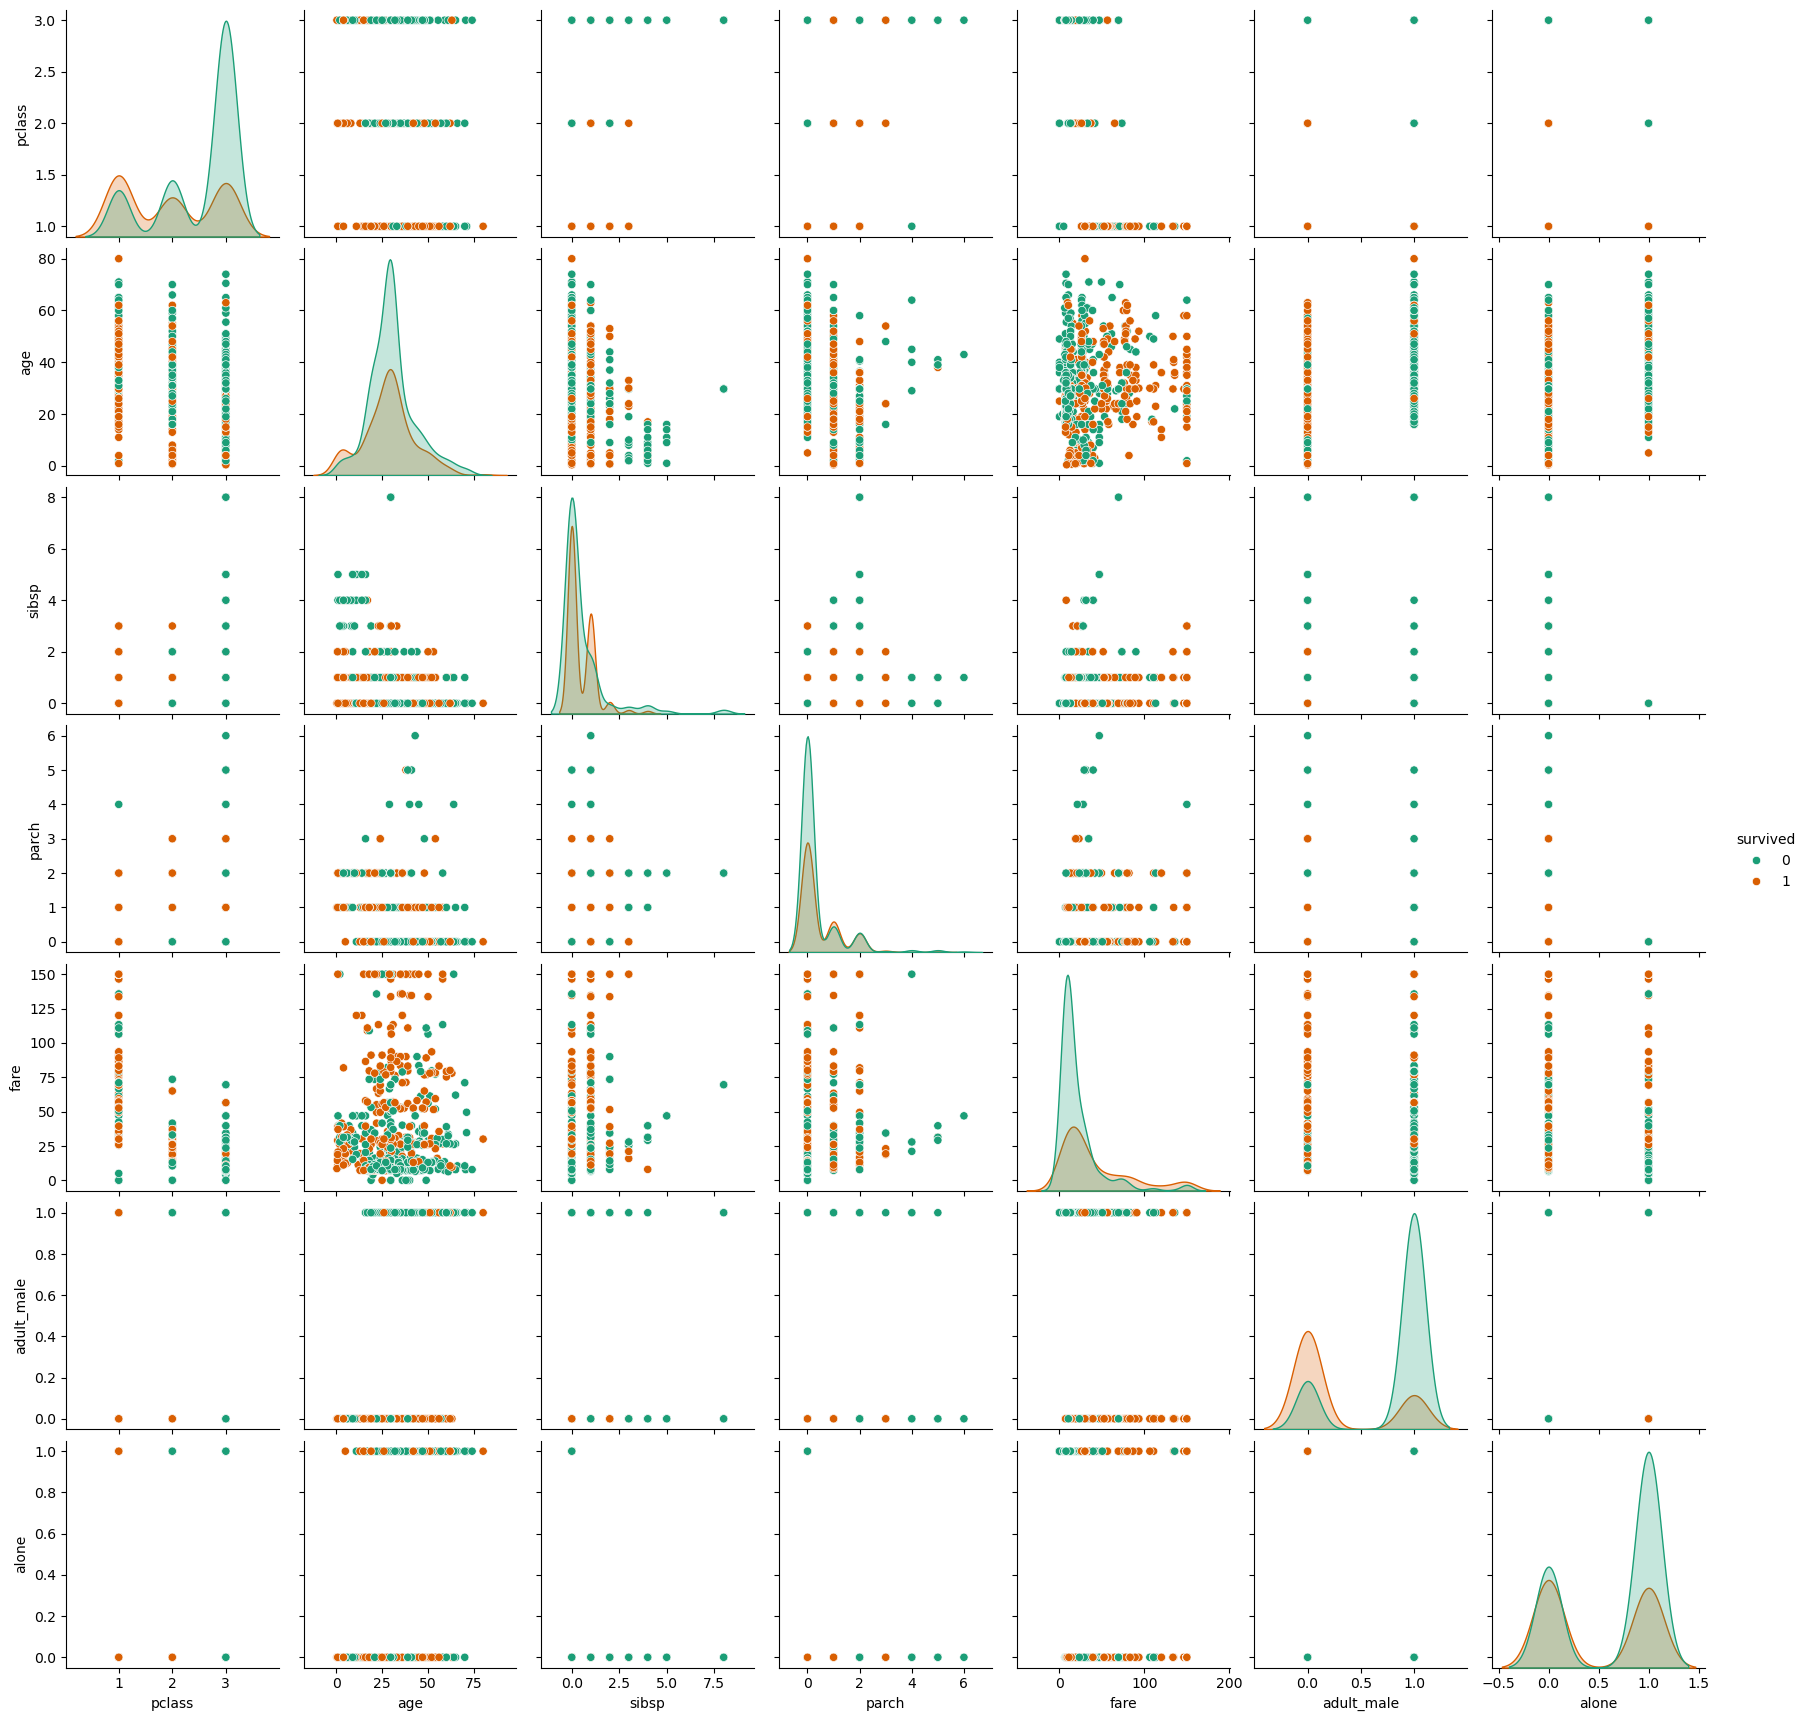

In [34]:
sns.pairplot(df.iloc[:,0:15],hue='survived',palette='Dark2') # just the original columns, not my normalized columns
plt.show()

**Assessment**

In this pair plot, we can infer that the combination of gender and pclass is probably going to be a good predictor, as the survivors appear to be clumped in one quandrant.  We can also see big spikes of non-survivors in the distributions: 3rd class and male.

Fare and pclass are not as correlated as you would expect.  It seems there were many first class passengers with lower fares than some third class passengers.

Age appears to be normally distributed, with a small standard deviation.  Apparently there were not very many children.  At the intersection of gender and age, it appears that most of the surviving males were older, and many male children did not survive.

**KDE plots**

In [19]:
df_survived = df[df['survived']==1]
sns.kdeplot( data=df_survived, x='GenderNumeric', y='pclass',
                 cmap="plasma", fill=True)

<Axes: xlabel='alone', ylabel='Density'>

In [20]:
df_not_survived = df[df['survived']==0]
sns.kdeplot( data=df_not_survived, x='GenderNumeric', y='pclass',
                 cmap="plasma", fill=True)

<Axes: xlabel='alone', ylabel='Density'>

### Train a Model

In [21]:
svc_model = SVC()
svc_model.fit(X_train,y_train)

SVC()

### Model Evaluation

Get predictions from the model and create a confusion matrix and a classification report

In [22]:
predictions = svc_model.predict(X_test)
print(confusion_matrix(y_test,predictions))

[[142  14]
 [ 75  37]]


In [23]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.65      0.91      0.76       156
           1       0.73      0.33      0.45       112

    accuracy                           0.67       268
   macro avg       0.69      0.62      0.61       268
weighted avg       0.68      0.67      0.63       268



**Assessment**

Given how gender, age, and class are known to be good predictors of who got in the lifeboats, I'm surprised the SVM model does not have a better overall accuracy than 69%.  Try applying PCA and repeating the model.  PCA has removed correlated features, for example beteween class and fare, or between adult_male and gender and age.

### SVM Model after PCA transformation

In [24]:
# train model
svc_model = SVC()
svc_model.fit(X_train_pc,y_train)

# predict and evaluate accuracy
predictions = svc_model.predict(X_test_pc)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[135  21]
 [ 63  49]]
              precision    recall  f1-score   support

           0       0.68      0.87      0.76       156
           1       0.70      0.44      0.54       112

    accuracy                           0.69       268
   macro avg       0.69      0.65      0.65       268
weighted avg       0.69      0.69      0.67       268



**Conclusion**

The SVM model technique is not as good with the Titanic data as it is with the Iris data.  PCA was very helpful for making a visulization with reduced dimensions, and as a result, I can see that the survivors and non-survivors are fairly heavily mixed in the PCA space, which means a linear division of the categories is not going to be very successful.  Applying the **kernel trick** to either the PCA transform, or the SVM model, would probably improve the accuracy of the model.